# Applying Corresponding Analysis to Textual Data


In [1]:
import pandas as pd

# read data

In [5]:
d=pd.read_csv("df_preliminary_covid.csv")
#d=pd.read_csv("small.csv")

In [6]:
d.head(5)

,canonical_url,domain,title,article_text,published_date,tags,article_text_lemmatized,title_lemmatized,tags_lemmatized
0,https://www.novilist.hr/novosti/hrvatska/kbc-r...,novilist.hr,KBC Rijeka povećao broj postelja za zaražene: ...,RIJEKA – Od koronavirusa jučer je u Hrvatskoj ...,2020-11-10 06:33:00,"krunoslav capak,epidemija koronavirusa,koronav...",rijeka – od koronavirusa jučer je u hrvatski u...,kbc rijeka povećati brojati postelja za zaraže...,"krunoslav capak , epidemija koronavirusa , kor..."
1,https://www.jutarnji.hr/vijesti/svijet/svedski...,jutarnji.hr,Švedski koronastrateg na udaru zbog emailova o...,Švedska strategija za borbu protiv epidemije k...,2020-08-17 18:50:00,"anders tegnell,švedska",švedski strategija za borba protiv epidemija k...,švedski koronastrateg na udar zbog emailova o ...,"anders tegnell , švedski"
2,https://www.index.hr/clanak.aspx?id=2208246,index.hr,Britanski epidemiolog: Lockdown je bio monumen...,"Lockdown će se smatrati ""monumentalnom pogrešk...",2020-08-27 00:00:00,"koronavirus,karantena,lockdown,markwoolhouse,k...","lockdown će se smatrati "" monumentalan pogrešk...",britanski epidemiolog : lockdown je biti monum...,"koronavirus , karantena , lockdown , markwoolh..."
3,https://www.jutarnji.hr/vijesti/hrvatska/umrla...,jutarnji.hr,UMRLA ŠTIĆENICA IZ DOMA UMIROVLJENIKA U SPLITU...,Županijski stožeri i danas objavljuju nove pod...,2020-04-10 09:49:00,"županije,koronavirus,zaraza,krizni stožer",županijski stožer i danas objavljivati nov pod...,umro štićenica iz dom umirovljenik u split rav...,"županija , koronavirus , zaraza , krizan stožer"
4,https://dnevnik.hr/vijesti/koronavirus/iz-minu...,dnevnik.hr,"Zaražen i ruski premijer, završio u izolaciji....",Više od tri milijuna ljudi diljem svijeta zara...,2020-04-30 22:29:00,"coronavirus,koronavirus,svijet,regija,covid-19",više od tri milijun čovjek dilj svijet zaražen...,"zaražen i ruski premijer , završiti u izolacij...","coronavirus , koronavirus , svijet , regija , ..."


In [9]:
d.shape

(19399, 9)

In [7]:
d=d.sample(frac=1)
domains= d.domain

In [8]:
classes=list(domains.value_counts().index[:10]                          )

<AxesSubplot:title={'center':'Media Outlers'}>

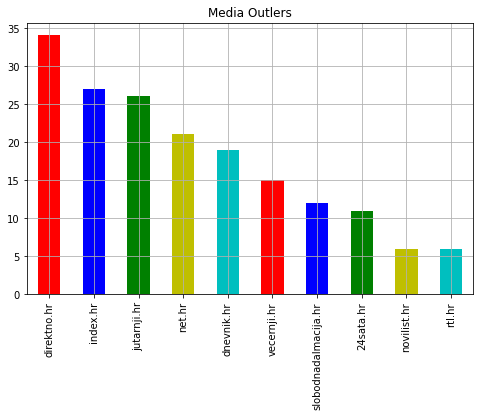

In [55]:
domains.value_counts()[classes].plot(kind='bar', color=["r","b","g","y","c"], title="Media Outlers", grid=True, figsize=(8,5))

In [56]:
classes

['direktno.hr',
 'index.hr',
 'jutarnji.hr',
 'net.hr',
 'dnevnik.hr',
 'vecernji.hr',
 'slobodnadalmacija.hr',
 '24sata.hr',
 'novilist.hr',
 'rtl.hr']

In [57]:
d2=d[d.domain.map(lambda x: x in classes)]
d2.shape

(177, 9)

In [58]:
titles= d2.title_lemmatized
titles.shape

(177,)

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer(ngram_range=(1,2), max_df=0.9, max_features=15000, min_df=5, lowercase=False)
X=vectorizer.fit_transform(titles)

In [60]:
X.shape

(177, 106)

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
clf=GradientBoostingClassifier()

In [62]:
domains=d2.domain
cut= X.shape[0]*3//4
print(cut,X.shape[0])
trainX= X[:cut]
trainY= domains[:cut]
testX= X[cut:]
testY= domains[cut:]

132 177


In [63]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((132, 106), (132,), (45, 106), (45,))

In [64]:
clf.fit(trainX,trainY)
pred=clf.predict(testX)

In [65]:
from sklearn.metrics import classification_report 
print(classification_report(y_true=testY, y_pred= pred))

                      precision    recall  f1-score   support

           24sata.hr       0.00      0.00      0.00         2
         direktno.hr       0.46      0.67      0.55         9
          dnevnik.hr       0.00      0.00      0.00         6
            index.hr       0.20      0.11      0.14         9
         jutarnji.hr       0.00      0.00      0.00         4
              net.hr       0.33      0.17      0.22         6
         novilist.hr       0.00      0.00      0.00         1
              rtl.hr       0.00      0.00      0.00         3
slobodnadalmacija.hr       0.00      0.00      0.00         3
         vecernji.hr       0.00      0.00      0.00         2

            accuracy                           0.18        45
           macro avg       0.10      0.09      0.09        45
        weighted avg       0.18      0.18      0.17        45



In [66]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true=testY, y_pred= pred)

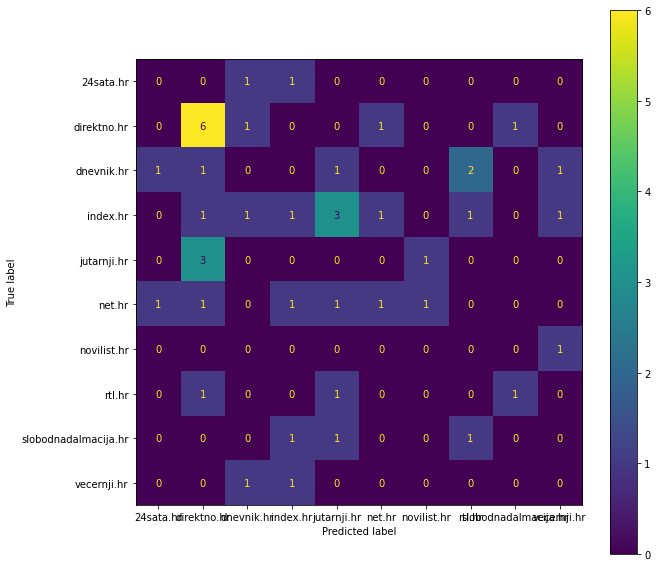

In [67]:
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

In [68]:
clf.fit(X,domains)

GradientBoostingClassifier()

In [69]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names))
    top = coefs_with_fns[:-(n + 1):-1] 
    return top

In [70]:
topn=show_most_informative_features(vectorizer,clf, n=350)
VOC=[e[1] for e in topn if len(e[1])>3]

In [71]:
len(VOC)

78

In [72]:
# null control

In [73]:
## find the tags from the lists

In [74]:
from pprint import pprint
pprint(" | ".join(VOC))

('korona virus | slovenija | koronavirusa | pacijent | čovjek | dati | najviše '
 '| covid 19 | znanstvenik | testiranje | koronavirusom | možda | covid | '
 'zaražen | novozaraženih | capak | imati | liječnik | zemlja | simptom | '
 'hrvatski | svijet | više od | ukupan | cjepivo | beroš | posto | zadnji | '
 'mjera | epidemija | širenje | splitski | mjeriti | koji | država | velik | '
 'slučaj | trebati | samoizolacija | koronavirus | otkriti | samo | '
 'dalmatinski | protiv | virus | dati je | rekordan brojati | respirator | '
 'osoba | zašto | karantena | nakon | korona | splitski dalmatinski | moći | '
 'biti | na respirator | je dati | brojati | županija | više | koronom | nije '
 '| kako | umro | nego | rekordan | stožer | preminuti | brojka | zaraziti | '
 'dobar | nov slučaj | plenković | oboljeo | borba | žarište | ministar')


In [75]:
len(VOC)

78

## What about domian - news source ?

it is not uniformly distributed. Now lets select only 10 domains

In [76]:
domain=list(d.domain.value_counts().index[:10])

In [77]:
classes

['direktno.hr',
 'index.hr',
 'jutarnji.hr',
 'net.hr',
 'dnevnik.hr',
 'vecernji.hr',
 'slobodnadalmacija.hr',
 '24sata.hr',
 'novilist.hr',
 'rtl.hr']

## building a cross matrix

In [78]:
import numpy as np
cross=np.zeros((len(classes) , len(VOC))) 
for dom,title in zip(d2.domain, d2.title_lemmatized):
    if not pd.isnull(title):
        if dom in classes:
            domi=classes.index(dom)
            #print("2 ",)
            for v in VOC:
                #print("3\t\t",t)
                vi=VOC.index(v)
                if " "+v+" " in " "+title+" ":
                    cross[domi, vi]=cross[domi, vi]+1

In [79]:
cross

array([[14.,  4.,  0.,  0.,  2.,  8.,  0.,  0.,  2.,  0.,  0.,  1.,  2.,
         1.,  2.,  0.,  2.,  0.,  1.,  0.,  3.,  0.,  1.,  0.,  2.,  4.,
         1.,  0.,  2.,  4.,  1.,  2.,  2.,  1.,  1.,  1.,  8.,  1.,  2.,
         0.,  2.,  1.,  2.,  3., 15.,  2.,  0.,  0.,  2.,  0.,  0.,  2.,
        15.,  0.,  1.,  2.,  0.,  2.,  1.,  2.,  1.,  0.,  1.,  3.,  1.,
         0.,  1.,  1.,  2.,  2.,  5.,  0.,  5.,  1.,  1.,  1.,  2.,  0.],
       [ 0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         3.,  0.,  0.,  4.,  1.,  0.,  0.,  3.,  1.,  0.,  1.,  3.,  1.,
         0.,  0.,  1.,  1.,  0.,  0.,  3.,  3.,  1.,  2.,  3.,  2.,  0.,
         0.,  1.,  0.,  0.,  2.,  2.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  2.,  2.,  1.,  0.,  1.,  1.,  2.],
       [ 0.,  1.,  2.,  4.,  3.,  4.,  1.,  0.,  2.,  0.,  2.,  0.,  1.,
         3.,  0.,  2.,  4.,  2.,  2.,  2.,  2.,  

In [80]:
cross.shape

(10, 78)

## Following cross table shows how many times a tag occurs in a source-domian

In [81]:
DomainTerms=pd.DataFrame(cross, index=["DOMAIN_"+c.upper() for c in classes], columns=VOC)
DomainTerms

,korona virus,slovenija,koronavirusa,pacijent,čovjek,dati,najviše,covid 19,znanstvenik,testiranje,...,preminuti,brojka,zaraziti,dobar,nov slučaj,plenković,oboljeo,borba,žarište,ministar
DOMAIN_DIREKTNO.HR,14.0,4.0,0.0,0.0,2.0,8.0,0.0,0.0,2.0,0.0,...,2.0,2.0,5.0,0.0,5.0,1.0,1.0,1.0,2.0,0.0
DOMAIN_INDEX.HR,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,2.0
DOMAIN_JUTARNJI.HR,0.0,1.0,2.0,4.0,3.0,4.0,1.0,0.0,2.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0
DOMAIN_NET.HR,0.0,2.0,1.0,2.0,5.0,2.0,0.0,0.0,3.0,2.0,...,2.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
DOMAIN_DNEVNIK.HR,0.0,0.0,1.0,1.0,3.0,2.0,2.0,0.0,1.0,2.0,...,3.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,1.0,1.0
DOMAIN_VECERNJI.HR,0.0,0.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
DOMAIN_SLOBODNADALMACIJA.HR,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
DOMAIN_24SATA.HR,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
DOMAIN_NOVILIST.HR,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
DOMAIN_RTL.HR,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
DomainTerms.shape

(10, 78)

## lets apply Corresponding Analysis

In [83]:
# some zero-freq checking
DomainTerms2=DomainTerms.iloc[:,list(DomainTerms.sum(axis=0)>5)]
DomainTerms2.shape

(10, 51)

In [84]:
DomainTerms2.T.to_csv("DomainTerms.csv")

In [85]:
DomainTerms2.columns=[e.replace(" ","_") for e  in DomainTerms2.columns]

In [86]:
import ca

In [87]:
res=ca.CA(DomainTerms2)

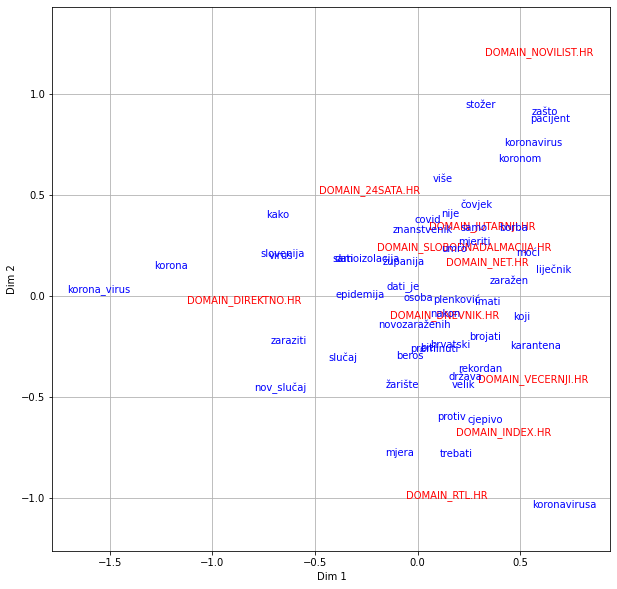

In [90]:
import matplotlib.pyplot as plt
#fig=plt.figure(400)
fig=plt.figure(figsize=(10,10))
res.plot()

In [91]:
fig.savefig('MARCH10.png')   # save the figure to file
plt.close(fig)

# WORD2VEC

In [34]:
corpus= [(e[0].upper() +" "+ e[1]).split() for e in zip(d2.domain, d2.title_lemmatized)]

In [92]:
def filt(liste):
    return [e for e in liste.split() if len(e)>3]

In [93]:
titles=  [d.upper()+" "+t for d, t in zip(d2.domain, d2.title_lemmatized)]

In [94]:
titles[0]

'DNEVNIK.HR u srbija preminuti 12 čovjek , na respirator do sad najviše oboljeo - 154 pacijent : " ovo je najgori dan "'

In [95]:
lemma=[filt(t) for t in list(titles)]

In [96]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [97]:
# Create Dictionary
id2word = corpora.Dictionary(lemma)

In [98]:
texts = lemma

In [99]:
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [100]:
id2word[8]

'čovjek'

In [101]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('DNEVNIK.HR', 1),
  ('najgori', 1),
  ('najviše', 1),
  ('oboljeo', 1),
  ('pacijent', 1),
  ('preminuti', 1),
  ('respirator', 1),
  ('srbija', 1),
  ('čovjek', 1)]]

In [102]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [103]:
pprint(lda_model.print_topics())

[(0,
  '0.110*"slučaj" + 0.097*"DIREKTNO.HR" + 0.065*"slovenija" + 0.062*"brojati" '
  '+ 0.055*"korona" + 0.054*"zaraziti" + 0.045*"rekordan" + 0.036*"virus" + '
  '0.035*"brojka" + 0.025*"zaraza"'),
 (1,
  '0.050*"koje" + 0.046*"imati" + 0.036*"zemlja" + 0.034*"JUTARNJI.HR" + '
  '0.022*"epidemiolog" + 0.022*"pitanje" + 0.022*"zaražen" + 0.022*"svijet" + '
  '0.022*"hrvat" + 0.022*"najveća"'),
 (2,
  '0.048*"umro" + 0.046*"preminuti" + 0.039*"respirator" + 0.035*"JUTARNJI.HR" '
  '+ 0.034*"podatak" + 0.033*"zaražen" + 0.032*"osoba" + 0.031*"mjeriti" + '
  '0.029*"više" + 0.024*"snaga"'),
 (3,
  '0.110*"virus" + 0.097*"korona" + 0.073*"DIREKTNO.HR" + 0.049*"slučaj" + '
  '0.036*"hrvatski" + 0.030*"velik" + 0.029*"mjeriti" + 0.029*"otkriti" + '
  '0.024*"INDEX.HR" + 0.022*"protiv"'),
 (4,
  '0.065*"ukupan" + 0.048*"hrvatski" + 0.041*"oboljeo" + 0.041*"život" + '
  '0.025*"poziv" + 0.017*"testiranje" + 0.013*"DNEVNIK.HR" + 0.011*"24SATA.HR" '
  '+ 0.009*"virus" + 0.009*"boriti"'),
 (5,


In [104]:
doc_lda = lda_model[corpus]

In [105]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.281763705126039

Coherence Score:  0.4100349342641957


In [106]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.169586 -0.175811       1        1  13.362371
13    -0.029147  0.034982       2        1   7.205291
19     0.088468 -0.086369       3        1   7.098067
5     -0.020927 -0.093572       4        1   6.673316
2      0.100587  0.148881       5        1   6.547038
9      0.061223 -0.048519       6        1   6.010358
6      0.010547 -0.044168       7        1   5.502975
0     -0.242246 -0.045170       8        1   5.391122
17     0.032190  0.066945       9        1   5.343268
16     0.010163  0.055178      10        1   4.899797
3     -0.175706 -0.058739      11        1   4.890630
18     0.018555 -0.074988      12        1   4.875209
12     0.046504  0.051536      13        1   4.229045
10    -0.042875  0.014771      14        1   3.750244
1      0.040858  0.025416      15        1   3.640566
7      0.019974  0.104298      16        1   3.158501
4     -0.014600  0.056514      17        1   2.726265
15    -0.036618  0.017166      18        1   2.317176
8     -0.036150  0.028536      19        1   1.866556
11    -0.000385  0.023112      20        1   0.512206, topic_info=            Term       Freq      Total Category  logprob  loglift
9    DIREKTNO.HR  27.000000  27.000000  Default  30.0000  30.0000
230       slučaj  17.000000  17.000000  Default  29.0000  29.0000
12        korona  16.000000  16.000000  Default  28.0000  28.0000
14         virus  22.000000  22.000000  Default  27.0000  27.0000
78          dati  20.000000  20.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
20          kroz   0.010012   1.287983  Topic20  -6.9007   0.4171
21      liječiti   0.010012   1.287983  Topic20  -6.9007   0.4171
22          ćemo   0.010012   3.913966  Topic20  -6.9007  -0.6943
23         alarm   0.010012   1.417365  Topic20  -6.9007   0.3214
24         beroš   0.010012  18.263623  Topic20  -6.9007  -2.2347

[846 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
348      13  0.766722      1000
425      13  0.766717      1377
398       5  0.717569      1945
537       6  0.721628   1970-ih
241      13  0.766717      2000
...     ...       ...       ...
536       7  0.737634     žlica
76        5  0.191156  županija
76        7  0.191156  županija
76       10  0.191156  županija
76       16  0.573469  županija

[746 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 20, 6, 3, 10, 7, 1, 18, 17, 4, 19, 13, 11, 2, 8, 5, 16, 9, 12])